In [ ]:
!pip install -q kaggle
!pip install -q scikit-image tqdm
!pip install -q scikit-image tqdm tensorflow

In [ ]:
# Requirements
import json
import os, glob
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import io
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
import json

# ----------------------------
# 1) CONFIG KAGGLE
# ----------------------------
kaggle_username = "Shayma Ben Jrad"
kaggle_key = "KGAT_4ceebe961136391758882bc1e935ad07"

# Créer ~/.kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Créer kaggle.json
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

# Permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nih-chest-xrays/data -p /content

Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
^C


In [ ]:
!unzip -q /content/data.zip -d /content/dataset
print("Dataset NIH dézippé dans /content/dataset/")

unzip:  cannot find or open /content/data.zip, /content/data.zip.zip or /content/data.zip.ZIP.
Dataset NIH dézippé dans /content/dataset/


In [ ]:
os.listdir("/content")

['.config', 'sample.zip', 'dataset', 'sample_data']

In [ ]:
!kaggle datasets download -d nih-chest-xrays/data -p /content

Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
^C


In [ ]:
import os
import json
from zipfile import ZipFile
import pandas as pd

# ----------------------------
# 1) CONFIG KAGGLE
# ----------------------------
kaggle_username = "Shayma Ben Jrad"
kaggle_key = "KGAT_4ceebe961136391758882bc1e935ad07"

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)
!chmod 600 /root/.kaggle/kaggle.json

!pip install -q kaggle

# ----------------------------
# 2) Télécharger le sample dataset (~5606 images)
# ----------------------------
download_path = "/content"
sample_slug = "nih-chest-xrays/sample"  # dataset Kaggle sample
!kaggle datasets download -d {sample_slug} -p {download_path} --force

# ----------------------------
# 3) Dézipper le sample dataset
# ----------------------------
zip_files = [f for f in os.listdir(download_path) if f.endswith(".zip")]
print("Fichiers ZIP trouvés :", zip_files)

dataset_dir = "/content/dataset"
os.makedirs(dataset_dir, exist_ok=True)

for zf in zip_files:
    with ZipFile(os.path.join(download_path, zf), 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

print("Sample Dataset NIH dézippé dans :", dataset_dir)

# ----------------------------
# 4) Lire le CSV
# ----------------------------
csv_path = os.path.join(dataset_dir, "Data_Entry_2017.csv")
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("Aperçu du CSV :")
    print(df.head())
    print("Nombre total d'images référencées :", len(df))
else:
    print("Le CSV 'Data_Entry_2017.csv' n'a pas été trouvé dans le dataset dézippé.")

Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample
License(s): CC0-1.0
 99% 4.17G/4.20G [01:05<00:00, 46.8MB/s]
100% 4.20G/4.20G [01:05<00:00, 68.8MB/s]
Fichiers ZIP trouvés : ['sample.zip']
Sample Dataset NIH dézippé dans : /content/dataset
Le CSV 'Data_Entry_2017.csv' n'a pas été trouvé dans le dataset dézippé.


In [ ]:
dataset_dir = "/content/dataset"
for root, dirs, files in os.walk(dataset_dir):
    print("Chemin :", root)
    print("Dossiers :", dirs)
    print("Fichiers :", files)
    print("-"*50)

Chemin : /content/dataset
Dossiers : ['sample']
Fichiers : ['sample_labels.csv']
--------------------------------------------------
Chemin : /content/dataset/sample
Dossiers : ['sample', 'images']
Fichiers : ['sample_labels.csv']
--------------------------------------------------
Chemin : /content/dataset/sample/sample
Dossiers : ['images']
Fichiers : []
--------------------------------------------------
Chemin : /content/dataset/sample/sample/images
Dossiers : []
Fichiers : ['00005909_003.png', '00007390_012.png', '00027726_050.png', '00008002_000.png', '00007352_000.png', '00012021_000.png', '00019766_001.png', '00016590_000.png', '00025394_002.png', '00004461_015.png', '00012905_000.png', '00028601_000.png', '00004169_000.png', '00021818_015.png', '00004992_000.png', '00025929_000.png', '00005119_002.png', '00015700_023.png', '00005372_005.png', '00003923_018.png', '00012378_000.png', '00013615_019.png', '00030634_000.png', '00025662_001.png', '00027368_005.png', '00014236_003.png',

In [ ]:
import os
import glob
import pandas as pd
from tqdm import tqdm
from skimage import io

# Chemins et CSV
DATASET_PATHS = [
    "/content/dataset/sample/images",
    "/content/dataset/sample/sample/images"
]
CSV_PATH = "/content/dataset/sample/sample_labels.csv"

# Lire les labels
df_labels = pd.read_csv(CSV_PATH)
df_labels = df_labels.set_index("Image Index")  # clé = nom du fichier
print("Nombre total d'images dans le CSV :", len(df_labels))

# Scanner les images
records = []

for data_path in DATASET_PATHS:
    files = sorted(glob.glob(os.path.join(data_path, "*")))
    for f in tqdm(files, desc=f"Scanning {data_path}"):
        filename = os.path.basename(f)
        label = df_labels.loc[filename, "Finding Labels"] if filename in df_labels.index else "Unknown"
        try:
            img = io.imread(f)
            h, w = img.shape[:2]
            fmt = os.path.splitext(f)[1].lower()
            records.append({
                "path": f,
                "class": label,
                "height": h,
                "width": w,
                "channels": img.ndim,
                "format": fmt,
                "ok": True
            })
        except Exception as e:
            records.append({
                "path": f,
                "class": label,
                "height": None,
                "width": None,
                "channels": None,
                "format": None,
                "ok": False,
                "error": str(e)
            })

# Créer DataFrame
df = pd.DataFrame(records)
print(df["class"].value_counts())
print("\nImage size stats:")
print(df[["height","width"]].describe())

# Fichiers corrompus ou problématiques
bad = df[df["ok"]==False]
if len(bad) > 0:
    print("\nCorrupted/unreadable images:")
    print(bad[["path","error"]])

# Vérifier doublons par nom de fichier
dupes = df['path'].apply(os.path.basename).value_counts()
dupes = dupes[dupes>1]
if len(dupes) > 0:
    print("\nDuplicate filenames detected (may be from different folders):")
    print(dupes)


Nombre total d'images dans le CSV : 5606


Scanning /content/dataset/sample/sample/images: 100%|██████████| 5606/5606 [01:18<00:00, 71.37it/s]

class
No Finding                                   6088
Infiltration                                 1006
Effusion                                      406
Atelectasis                                   384
Nodule                                        288
                                             ... 
Cardiomegaly|Consolidation|Infiltration         2
Emphysema|Pleural_Thickening|Pneumothorax       2
Atelectasis|Consolidation|Effusion|Mass         2
Consolidation|Effusion|Pneumonia                2
Cardiomegaly|Effusion|Emphysema                 2
Name: count, Length: 244, dtype: int64

Image size stats:
        height    width
count  11212.0  11212.0
mean    1024.0   1024.0
std        0.0      0.0
min     1024.0   1024.0
25%     1024.0   1024.0
50%     1024.0   1024.0
75%     1024.0   1024.0
max     1024.0   1024.0

Duplicate filenames detected (may be from different folders):
path
00030797_000.png    2
00000013_005.png    2
00000013_026.png    2
00000017_001.png    2
00000030_001.p

In [ ]:
import os
import glob
import pandas as pd
from tqdm import tqdm
from skimage import io

# 1) Chemins
CSV_PATH = "/content/dataset/sample/sample_labels.csv"
IMAGE_DIRS = [
    "/content/dataset/sample/images",
    "/content/dataset/sample/sample/images"
]

# 2) Lire le CSV
df_labels = pd.read_csv(CSV_PATH)
df_labels = df_labels.set_index("Image Index")  # clé = nom du fichier
print("Nombre total d'images dans le CSV :", len(df_labels))

# 3) Scanner les images
records = []

seen_files = set()  # Pour éviter les doublons
for data_path in IMAGE_DIRS:
    files = sorted(glob.glob(os.path.join(data_path, "*")))
    for f in tqdm(files, desc=f"Scanning {data_path}"):
        filename = os.path.basename(f)
        if filename in seen_files:
            continue  # ignore les doublons
        seen_files.add(filename)

        label = df_labels.loc[filename, "Finding Labels"] if filename in df_labels.index else "Unknown"
        try:
            img = io.imread(f)
            h, w = img.shape[:2]
            fmt = os.path.splitext(f)[1].lower()
            records.append({
                "path": f,
                "class": label,
                "height": h,
                "width": w,
                "channels": img.ndim,
                "format": fmt,
                "ok": True
            })
        except Exception as e:
            records.append({
                "path": f,
                "class": label,
                "height": None,
                "width": None,
                "channels": None,
                "format": None,
                "ok": False,
                "error": str(e)
            })

# 4) Créer DataFrame
df = pd.DataFrame(records)
print("\nNombre d'images uniques :", len(df))
print("\nDistribution des classes :")
print(df["class"].value_counts())

# 5) Statistiques tailles
print("\nImage size stats:")
print(df[["height","width"]].describe())

# 6) Fichiers corrompus
bad = df[df["ok"]==False]
if len(bad) > 0:
    print("\nCorrupted/unreadable images:")
    print(bad[["path","error"]])

# 7) Multi-labels binaires (optionnel)
all_labels = set()
for x in df["class"]:
    for lbl in str(x).split("|"):
        all_labels.add(lbl)
all_labels = sorted(list(all_labels))
print("\nToutes les pathologies :", all_labels)

for lbl in all_labels:
    df[lbl] = df["class"].apply(lambda x: int(lbl in str(x)))

print("\nAperçu final du DataFrame :")
print(df.head())

Nombre total d'images dans le CSV : 5606


Scanning /content/dataset/sample/sample/images: 100%|██████████| 5606/5606 [00:00<00:00, 1150580.75it/s]


Nombre d'images uniques : 5606

Distribution des classes :
class
No Finding                                   3044
Infiltration                                  503
Effusion                                      203
Atelectasis                                   192
Nodule                                        144
                                             ... 
Cardiomegaly|Consolidation|Infiltration         1
Emphysema|Pleural_Thickening|Pneumothorax       1
Atelectasis|Consolidation|Effusion|Mass         1
Consolidation|Effusion|Pneumonia                1
Cardiomegaly|Effusion|Emphysema                 1
Name: count, Length: 244, dtype: int64

Image size stats:
       height   width
count  5606.0  5606.0
mean   1024.0  1024.0
std       0.0     0.0
min    1024.0  1024.0
25%    1024.0  1024.0
50%    1024.0  1024.0
75%    1024.0  1024.0
max    1024.0  1024.0

Toutes les pathologies : ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# 1) Transformations images
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # redimensionne toutes les images
    transforms.ToTensor(),           # convertit en Tensor
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalisation simple
])

# 2) Dataset PyTorch
class NIHChestXrayDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        df : DataFrame contenant 'path' + 'class' (labels comme chaînes)
        transform : transformations torchvision à appliquer
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        image = Image.open(img_path).convert("RGB")  # forcer RGB
        if self.transform:
            image = self.transform(image)

        label = self.df.loc[idx, "class"]  # label sous forme de chaîne
        return image, label

# 3) Créer le dataset et dataloader
dataset = NIHChestXrayDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# 4) Vérification d'un batch
images, labels = next(iter(dataloader))
print("Batch d'images :", images.shape)       # ex: torch.Size([32, 3, 224, 224])
print("Batch de labels :", labels[:5])        # labels comme chaînes

Batch d'images : torch.Size([32, 3, 224, 224])
Batch de labels : ('Effusion', 'Effusion', 'No Finding', 'Cardiomegaly', 'Infiltration')


In [ ]:
# Créer une nouvelle colonne 'simple_label'
df['simple_label'] = df['class'].apply(lambda x: "Normal" if x=="No Finding" else "Malade")

# Vérifier
print(df['simple_label'].value_counts())

simple_label
Normal    3044
Malade    2562
Name: count, dtype: int64


In [ ]:
class NIHChestXraySimpleDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        df : DataFrame contenant 'path' et 'simple_label'
        transform : transformations torchvision
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        # Mapping texte → entier pour PyTorch
        self.label2idx = {"Normal":0, "Malade":1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label_text = self.df.loc[idx, "simple_label"]
        label = torch.tensor(self.label2idx[label_text], dtype=torch.long)
        return image, label

In [ ]:
dataset_simple = NIHChestXraySimpleDataset(df, transform=transform)
dataloader_simple = DataLoader(dataset_simple, batch_size=32, shuffle=True, num_workers=2)

# Vérification
images, labels = next(iter(dataloader_simple))
print("Batch d'images :", images.shape)       # torch.Size([32, 3, 224, 224])
print("Batch de labels :", labels[:10])       # labels = 0 (Normal) ou 1 (Malade)

Batch d'images : torch.Size([32, 3, 224, 224])
Batch de labels : tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 1])


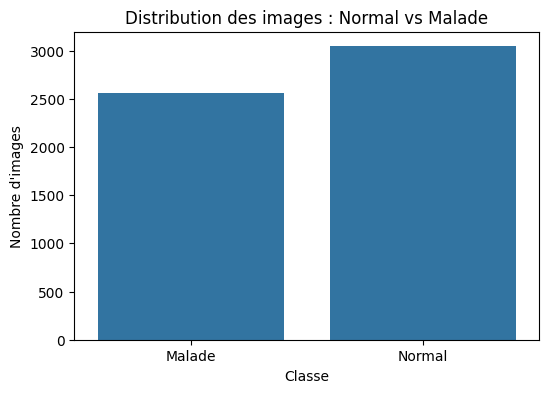

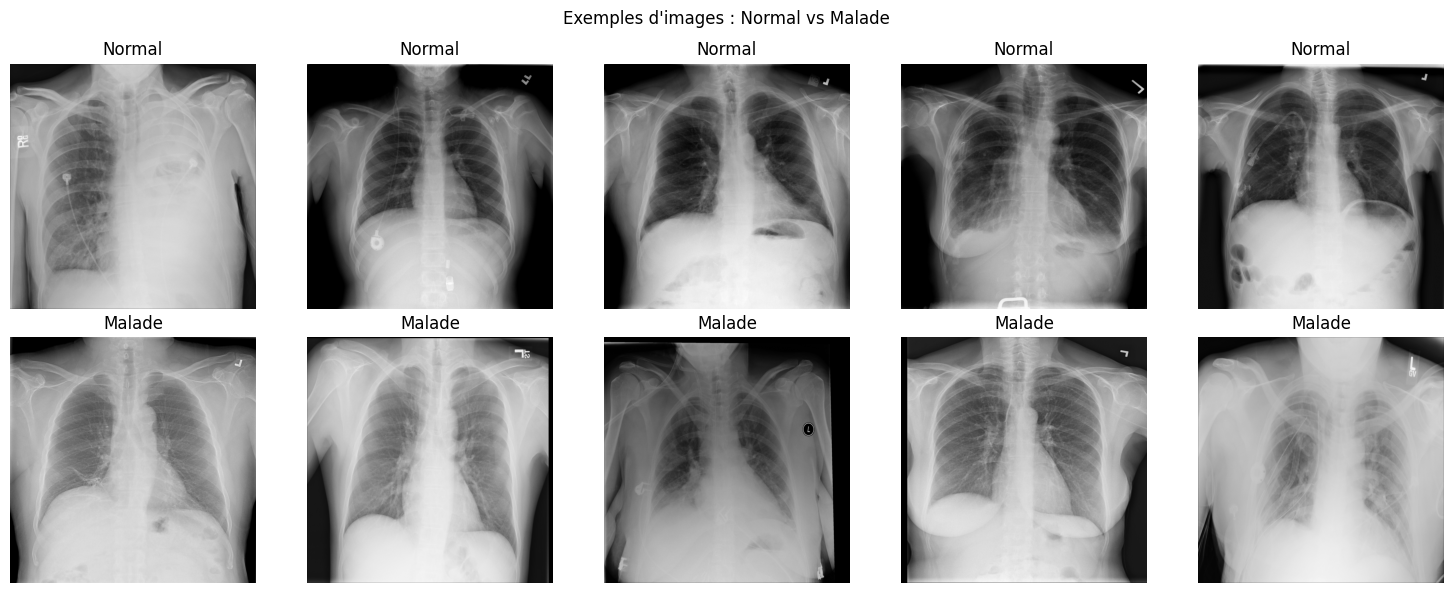

In [ ]:
import matplotlib.pyplot as plt
from skimage import io
import random

# 1) Distribution Normal / Malade
plt.figure(figsize=(6,4))
sns.countplot(x="simple_label", data=df)
plt.title("Distribution des images : Normal vs Malade")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()

# 2) Aperçu d'images aléatoires
fig, axes = plt.subplots(2,5, figsize=(15,6))

# Sélectionner 5 images Normal et 5 images Malade
normal_imgs = df[df['simple_label']=="Normal"].sample(5)
malade_imgs = df[df['simple_label']=="Malade"].sample(5)
sample_imgs = pd.concat([normal_imgs, malade_imgs])

for i, (idx, row) in enumerate(sample_imgs.iterrows()):
    ax = axes.flatten()[i]
    img_path = row['path']
    img = io.imread(img_path)

    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)

    ax.set_title(row['simple_label'])
    ax.axis('off')

plt.suptitle("Exemples d'images : Normal vs Malade")
plt.tight_layout()
plt.show()

In [ ]:
# Dataset path & classes
DATASET_PATH = "/content/dataset/sample/images"  # dossier contenant toutes les images
CLASSES = ["Normal", "Malade"]                    # labels simplifiés
IMG_SIZE = 224                                   # taille d'image pour le modèle
AUTOTUNE = tf.data.AUTOTUNE                      # pour tf.data pipelines

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 1) Labels numériques
label_map = {"Normal":0, "Malade":1}
df["label"] = df["simple_label"].map(label_map)  # utiliser la colonne simplifiée

# 2) Splits stratifiés
X = df['path'].values
y = df['label'].values

# Train / Val+Test
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Val / Test
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# 3) Fonction de chargement et prétraitement
def load_and_preprocess(path, label):
    # Load image
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 0.5) - 1.0   # => [-1,1] (équivalent à (img*2)-1)
    return img, label

# 4) Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomTranslation(0.02,0.02),
    tf.keras.layers.RandomContrast(0.08),
])

# 5) Création de datasets TF
BATCH_SIZE = 32

def create_tf_dataset(paths, labels, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# 6) Datasets finaux
train_ds = create_tf_dataset(X_train, y_train, augment=True)
val_ds = create_tf_dataset(X_val, y_val)
test_ds = create_tf_dataset(X_test, y_test)

Train: 3924 | Val: 841 | Test: 841


In [ ]:
import os
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Extract classes automatically
classes = df['simple_label'].unique().tolist()
label_map = {cls: i for i, cls in enumerate(classes)}

# Convert labels to numeric
X = df['path'].values
y = df['simple_label'].map(label_map).values

# ------------------------------
# Train / Val / Test split
# ------------------------------
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# ------------------------------
# Create folders and copy images
# ------------------------------
base_dir = "/content/dataset_split"
for split, X_split, y_split in zip(["train", "test"], [X_train, X_test], [y_train, y_test]):
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

    for path, label in zip(X_split, y_split):
        cls_name = classes[label]
        dst = os.path.join(base_dir, split, cls_name, os.path.basename(path))
        shutil.copy(path, dst)

# Verify counts
for split in ["train", "test"]:
    total = sum(len(os.listdir(os.path.join(base_dir, split, cls))) for cls in classes)
    print(f"{split} images:", total)

# ------------------------------
# TensorFlow datasets
# ------------------------------
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 0.5) - 1.0
    return img, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomTranslation(0.02,0.02),
    tf.keras.layers.RandomContrast(0.08),
])

def create_tf_dataset(paths, labels, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = create_tf_dataset(X_train, y_train, augment=True)
val_ds   = create_tf_dataset(X_val, y_val)
test_ds  = create_tf_dataset(X_test, y_test)

Train: 3924 | Val: 841 | Test: 841
Batch d'images : (32, 224, 224, 3)
Batch de labels : [1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1]


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 0.5) - 1.0
    return img, label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2)
])

def create_tf_dataset(paths, labels, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(2048).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

def create_initial_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False,
                             input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # on gèle le modèle de base

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)  # pas d'augmentation ici
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(1e-4),
        loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2),
        metrics=['accuracy']
    )
    return model

train_ds = create_tf_dataset(X_train, y_train, augment=True)
val_ds   = create_tf_dataset(X_val, y_val, augment=False)
test_ds  = create_tf_dataset(X_test, y_test, augment=False)

y_train_np = np.concatenate([y for x,y in train_ds], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

print("\n=== PHASE 1 : Entraînement du classifieur ===\n")
model = create_initial_model()
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks_list
)

# PHASE 2 : Fine-tuning profond
print("\n=== PHASE 2 : Fine-tuning profond ===\n")
base_model = model.layers[1]  # MobileNetV2 est la 2e couche du modèle
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(1e-5),
    loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2),
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks_list
)

y_pred = (model.predict(test_ds) > 0.5).astype(int)
y_true = np.concatenate([y for x,y in test_ds], axis=0)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


=== PHASE 1 : Entraînement du classifieur ===

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 132s 557ms/step - accuracy: 0.5364 - loss: 0.3335 - val_accuracy: 0.5624 - val_loss: 0.2136 - learning_rate: 1.0000e-04
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 124s 475ms/step - accuracy: 0.5595 - loss: 0.2090 - val_accuracy: 0.5743 - val_loss: 0.1783 - learning_rate: 1.0000e-04
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 109s 481ms/step - accuracy: 0.5735 - loss: 0.1871 - val_accuracy: 0.5791 - val_loss: 0.1840 - learning_rate: 1.0000e-04
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 141s 471ms/step - accuracy: 0.5850 - loss: 0.1769 - val_accuracy: 0.6136 - val_loss: 0.1728 - learning_rate: 1.0000e-04
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 108s 482ms/step - accuracy: 0.5986 - loss: 0.1723 - val_accuracy: 0.6064 - val_loss: 0.1734 - learning_rate: 1.0000e-04
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 110s 488ms/step - accuracy: 0.6063 - loss: 0.1691 - val_accuracy: 0.6159 - val_loss: 0.1684 - learning_rate: 1.0

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Dataset paths and labels
classes = df['simple_label'].unique().tolist()  # extract classes automatically
label_map = {cls: i for i, cls in enumerate(classes)}

X = df['path'].values
y = df['simple_label'].map(label_map).values  # convert to numeric

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")

# Create folders and copy images
base_dir = "/content/dataset_splitted"  # Colab folder
for split, X_split, y_split in zip(["train", "test"], [X_train, X_test], [y_train, y_test]):
    # create class subfolders
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

    # copy images into the proper folder
    for path, label in zip(X_split, y_split):
        cls_name = classes[label]  # convert numeric label back to class name
        dst = os.path.join(base_dir, split, cls_name, os.path.basename(path))
        shutil.copy(path, dst)

# Verify counts
for split in ["train", "test"]:
    total = sum(len(os.listdir(os.path.join(base_dir, split, cls))) for cls in classes)
    print(f"{split} images:", total)

Train: 4484 | Test: 1122
train images: 4484
test images: 1122


In [ ]:
import shutil
from google.colab import files

# Chemin vers ton dossier contenant train et test
base_dir = "/content/dataset_splitted"

# Créer un fichier zip
shutil.make_archive(base_dir, 'zip', base_dir)  # crée dataset_split_v2.zip

# Télécharger le zip
files.download(base_dir + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>